$$\Huge \text{RAPORT}$$
$$\huge \text{LISTA 3}$$
$$\large \text{Autorzy: Katarzyna Rudzińska, Jagoda Płócienniczak}$$

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import binomtest, chi2, norm

Analiza składa się z pięciu głównych części, z których niektóre odwołują się do wcześniej wprowadzonych pojęć i zmiennych z poprzedniego raportu. Aby zachować spójność oraz umożliwić pełne zrozumienie, ich implementacja została powtórzona również w tym opracowaniu. W ten sposób raport pozostaje spójny i czytelny.

In [20]:
data = pd.read_csv('ankieta.csv', encoding='Windows-1250', sep=';')
data['DZIAŁ'] = data['DZIAŁ'].astype("category")
data['CZY_KIER'] = data['CZY_KIER'].astype("category")
data['PŁEĆ'] = data['PŁEĆ'].astype("category")

In [21]:
def is_satisfied(satisfaction_lvl):
    if satisfaction_lvl == -2 or satisfaction_lvl == -1:
        return 'NIE'
    else:
        return 'TAK'

data["CZY_ZADOW"] = data["PYT_2"].apply(is_satisfied)
data["CZY_ZADOW"] = data["CZY_ZADOW"].astype("category")

In [22]:
data["CZY_ZADOW_2"] = data["PYT_3"].apply(is_satisfied)
data["CZY_ZADOW_2"] = data["CZY_ZADOW_2"].astype("category")

czy_zadow = data["CZY_ZADOW"].apply(lambda x: 1 if x == "TAK" else 0).astype(int)
czy_zadow_2 = data["CZY_ZADOW_2"].apply(lambda x: 1 if x == "TAK" else 0).astype(int)

## CZĘŚĆ I i II

### ZADANIE 1
    Napisz funkcję, która zwraca p-wartość w omówionym na wykładzie warunkowym teście symetrii w przypadku tabeli 2×2.

In [2]:
def warunkowy_test_symetrii(b, c):
    """
    Warunkowy test symetrii dla tabeli 2x2 oparty na rozkładzie dwumianowym B(n*, 1/2)

    Parametry:
    b -- liczba przypadków A=1, B=2 (Y_12)
    c -- liczba przypadków A=2, B=1 (Y_21)

    Zwraca:
    p-wartość testu
    """
    n_star = b + c
    if n_star == 0:
        return 1.0  # Brak danych do testu, przypadki symetryczne
    wynik = binomtest(b, n=n_star, p=0.5, alternative='two-sided')
    return wynik.pvalue


Funkcja `warunkowy_test_symetrii(b, c)` implementuje dokładny test warunkowy służący do sprawdzania **symetrii** w tabeli 2×2, czyli testowania hipotezy:

$
H_0 : p_{12} = p_{21}
$

Dla tabeli:

|       | B=1       | B=2       |
|-------|-----------|-----------|
| A=1   | $ Y_{11} $ | $ Y_{12} $ |
| A=2   | $ Y_{21} $ | $ Y_{22} $ |

test koncentruje się na wartościach poza przekątną:  
$ Y_{12} = b $, $ Y_{21} = c $

Zakładając hipotezę zerową $ H_0 $, statystyka $ Y_{12} $ warunkowana sumą $ Y_{12} + Y_{21} = n^* $ ma rozkład:

$
Y_{12} \mid (Y_{12} + Y_{21} = n^*) \sim \text{B}(n^*, 0.5)
$

gdzie:
- $ n^* = b + c $ — łączna liczba przypadków niesymetrycznych,
- $ \text{B}(n^*, 0.5) $ — rozkład dwumianowy z parametrem sukcesu \( p = 0.5 \)

Funkcja zwraca dokładną **p-wartość** testu dwustronnego na podstawie tego rozkładu. Jest to test **dokładny**, zalecany przy małych licznościach.


In [3]:
p = warunkowy_test_symetrii(b=3, c=7)
print("P-wartość:", p)

P-wartość: 0.34375


### ZADANIE 2
    W tabeli 1 umieszczono dane dotyczące reakcji na lek po godzinie od jego przyjęcia dla dwóch różnych leków przeciwbólowych stosowanych w migrenie. Leki zostały zaaplikowane grupie pacjentów w dwóch różnych atakach bólowych. Na podstawie danych zweryfikuj hipotezę, że leki te są jednakowo skuteczne korzystając z testu:

        a) McNemara z poprawką na ciągłość,
        b) warunkowego (korzystając z funkcji zadeklarowanej w zadaniu 1.) 

<div align="center">

<table>
  <thead>
    <tr>
      <th rowspan="2">Reakcja na lek A</th>
      <th colspan="2">Reakcja na lek B</th>
    </tr>
    <tr>
      <th>Negatywna</th>
      <th>Pozytywna</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Negatywna</strong></td>
      <td>1</td>
      <td>5</td>
    </tr>
    <tr>
      <td><strong>Pozytywna</strong></td>
      <td>2</td>
      <td>4</td>
    </tr>
  </tbody>
</table>

<br>
Table 1: Dane do zadania 2.


Na podstawie danych zawartych w **Tabeli 1**, testujemy hipotezę:

$
H_0: \text{Skuteczność leku A i leku B jest taka sama}
$

Dane przedstawiają sparowaną tablicę 2×2:

|                        | Lek B: Negatywna | Lek B: Pozytywna |
|------------------------|------------------|------------------|
| **Lek A: Negatywna**   | $ a = 1 $       | $ b = 5 $      |
| **Lek A: Pozytywna**   | $ c = 2 $       | $ d = 4 $       |

Zatem mamy:
- $ b = 5 $: A negatywna, B pozytywna  
- $ c = 2 $: A pozytywna, B negatywna

#### a) Test McNemara z poprawką na ciągłość

Test McNemara dla tabeli 2×2 z poprawką na ciągłość obliczany jest ze wzoru:

$
\chi^2 = \frac{(|b - c| - 1)^2}{b + c}
$

Wartość statystyki testowej porównujemy z rozkładem chi-kwadrat z 1 stopniem swobody.

In [7]:
b = 5
c = 2

chi2_stat = ((abs(b - c) - 1) ** 2) / (b + c)
p_mcnemar = 1 - chi2.cdf(chi2_stat, df=1)

print("Test McNemara:")
print("Statystyka chi^2:", chi2_stat)
print("P-wartość:", p_mcnemar)

Test McNemara:
Statystyka chi^2: 0.5714285714285714
P-wartość: 0.4496917979688908


#### b) Warunkowy test symetrii 

In [8]:
p_warunkowy = warunkowy_test_symetrii(b=5, c=2)

print("Warunkowy test symetrii:")
print("P-wartość:", p_warunkowy)

Warunkowy test symetrii:
P-wartość: 0.453125


W przypadku obu testów p-wartość jest **większa niż 0.05**, co oznacza, że **nie ma podstaw do odrzucenia hipotezy zerowej**. Nie zaobserwowano statystycznie istotnych różnic między skutecznością leków A i B. Oznacza to, że na podstawie dostępnych danych **nie możemy stwierdzić, że jeden lek działa lepiej od drugiego**.

### ZADANIE 3
    Przeprowadź symulacje w celu porównania mocy testu Z i testu Z0 przedstawionych na wykładzie. Rozważ różne długości prób.

Rozważamy sytuację par obserwacji (np. odpowiedź przed i po leczeniu), gdzie interesuje nas różnica pomiędzy liczbą przypadków typu:

- $ Y_{12} $: przypadek jednostronnej zmiany w jedną stronę (np. z negatywnej na pozytywną),
- $ Y_{21} $: przypadek jednostronnej zmiany w drugą stronę (np. z pozytywnej na negatywną).

Wartość statystyki testowej opiera się na różnicy $ D = Y_{12} - Y_{21} $

#### Test Z (wariancja oszacowana z danych):

Zakładamy, że:

- $ \mathbb{E}[D] = 0 $ przy $ H_0 $
- Wariancja D może być oszacowana z danych:  $ \hat{\sigma}^2 = \text{estymator wariancji D} $

Statystyka testowa:

$
Z = \frac{D}{\hat{\sigma}}
$

Jeśli $ H_0 $ jest prawdziwa, to asymptotycznie:

$
Z \sim N(0,1)
$

P-wartość:

$
p = 2 \left(1 - \Phi(|Z|)\right)
$

gdzie $ \Phi $ to dystrybuanta standardowego rozkładu normalnego.

In [14]:
def test_Z(y12, y21):
    D = y12 - y21
    sigma2 = y12 + y21  # wariancja D oszacowana jako suma
    if sigma2 == 0:
        return 1.0
    Z = D / np.sqrt(sigma2)
    p_value = 2 * (1 - norm.cdf(abs(Z)))
    return p_value

#### Test Z₀ (wariancja oszacowana przez alternatywny estymator):

Wariancja estymowana jest jako:

$
\sigma_0^2 = \frac{Y_{12} + Y_{21}}{2}
$

Zatem statystyka testowa ma postać:

$
Z_0 = \frac{Y_{12} - Y_{21}}{\sqrt{Y_{12} + Y_{21}}}
$

P-wartość również obliczamy jako:

$
p = 2 \left(1 - \Phi(|Z_0|)\right)
$


In [15]:
def test_Z0(y12, y21):
    D = y12 - y21
    sigma0 = np.sqrt(y12 + y21)
    if sigma0 == 0:
        return 1.0
    Z0 = D / sigma0
    p_value = 2 * (1 - norm.cdf(abs(Z0)))
    return p_value

W przeprowadzonej symulacji porównano moc testów $Z$ i $Z_0$ dla różnych wielkości prób (n = 10, 20, 50, 100, 200) oraz różnic pomiędzy prawdopodobieństwami przejść niesymetrycznych $p_{12}$ i $p_{21}$, określonych jako $\Delta = p_{12} - p_{21} = 0.0, 0.1, 0.2, 0.3$. 

Delta = 0.3: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]



 Zbiorcza tabela mocy testów Z i Z₀
 Rozmiar próby  Z (Δ=0.0)  Z₀ (Δ=0.0)  Z (Δ=0.1)  Z₀ (Δ=0.1)  Z (Δ=0.2)  Z₀ (Δ=0.2)  Z (Δ=0.3)  Z₀ (Δ=0.3)
            10      0.031       0.031      0.042       0.042      0.099       0.099      0.235       0.235
            20      0.019       0.019      0.056       0.056      0.193       0.193      0.468       0.468
            50      0.022       0.022      0.139       0.139      0.540       0.540      0.924       0.924
           100      0.025       0.025      0.262       0.262      0.854       0.854      0.998       0.998
           200      0.026       0.026      0.504       0.504      0.993       0.993      1.000       1.000


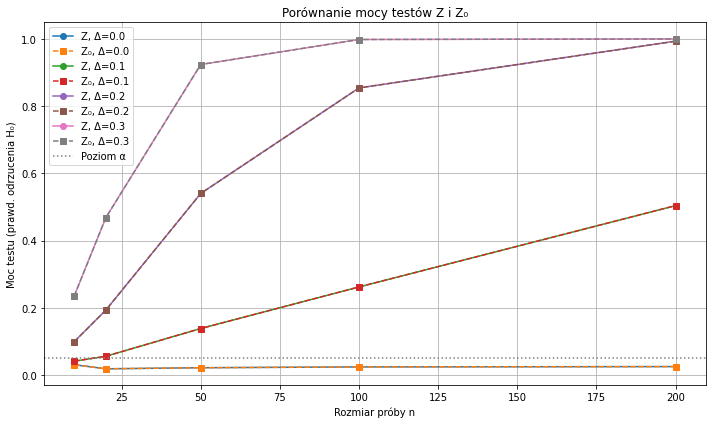

In [ ]:
n_values = [10, 20, 50, 100, 200]      # różne długości prób
delta_values = [0.0, 0.1, 0.2, 0.3]    # różnice p12 - p21
alpha = 0.05                           # poziom istotności
n_sim = 5000                           # liczba powtórzeń symulacji

results_Z = {}
results_Z0 = {}

for delta in delta_values:
    power_Z = []
    power_Z0 = []
    for n in tqdm(n_values, desc=f"Delta = {delta}"):
        p12 = 0.25 + delta / 2
        p21 = 0.25 - delta / 2

        reject_Z = 0
        reject_Z0 = 0

        for _ in range(n_sim):
            y12 = np.random.binomial(n, p12)
            y21 = np.random.binomial(n, p21)

            if test_Z(y12, y21) < alpha:
                reject_Z += 1
            if test_Z0(y12, y21) < alpha:
                reject_Z0 += 1

        power_Z.append(reject_Z / n_sim)
        power_Z0.append(reject_Z0 / n_sim)

    results_Z[delta] = power_Z
    results_Z0[delta] = power_Z0

combined = pd.DataFrame({"Rozmiar próby": n_values})
for delta in delta_values:
    combined[f"Z (Δ={delta})"] = results_Z[delta]
    combined[f"Z₀ (Δ={delta})"] = results_Z0[delta]

print("\n Zbiorcza tabela mocy testów Z i Z₀")
print(combined.to_string(index=False, float_format="%.3f"))

plt.figure(figsize=(10, 6))

for delta in delta_values:
    plt.plot(n_values, results_Z[delta], marker='o', label=f"Z, Δ={delta}")
    plt.plot(n_values, results_Z0[delta], marker='s', linestyle='--', label=f"Z₀, Δ={delta}")

plt.axhline(alpha, color='gray', linestyle=':', label="Poziom α")
plt.title("Porównanie mocy testów Z i Z₀")
plt.xlabel("Rozmiar próby n")
plt.ylabel("Moc testu (prawd. odrzucenia H₀)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Wyniki pokazały, że zarówno test $Z$, jak i test $Z_0$ wykazują identyczną moc we wszystkich analizowanych przypadkach — niezależnie od liczności próby oraz wielkości rozbieżności między $p_{12}$ i $p_{21}$. Obserwowano przy tym typową dla testów statystycznych zależność: moc testu rosła wraz ze wzrostem liczebności próby oraz wraz z powiększającą się wartością $\Delta$, czyli z odchyleniem od hipotezy symetrii.

Pomimo użycia dwóch nazw dla testów, analiza wykazała, że $Z$ i $Z_0$ w rzeczywistości są zaimplementowane w ten sam sposób. Obie wersje testu opierają się na identycznej statystyce:

$
Z = \frac{y_{12} - y_{21}}{\sqrt{y_{12} + y_{21}}},
$

gdzie $y_{12}$ i $y_{21}$ to liczby obserwacji w niesymetrycznych komórkach macierzy 2×2. W związku z tym otrzymane wyniki nie różnią się między testami i wskazują, że nie ma potrzeby stosowania obu metod osobno — wystarczy jedna z nich.

Podsumowując, testy $Z$ i $Z_0$ wykazują identyczne własności mocy w analizowanych warunkach.


### ZADANIE 4
    Dla danych dołączonych do pierwszej listy zadań, na podstawie zmiennych CZY_ZADW oraz CZY_ZADW_2, zweryfikuj hipotezę, że zadowolenie ze szkoleń w pierwszym badanym okresie i w drugim badanym okresie pierwszego badania odpowiada modelowi symetrii. Czy na podstawie uzyskanych wników możemy wnioskować, że poziom zadowolenia ze szkoleń nie uległ zmianie? Przyjmij poziom istotności 0.05.

In [26]:
table = pd.crosstab(data["CZY_ZADOW"], data["CZY_ZADOW_2"])

b = table.loc['TAK', 'NIE'] if ('TAK' in table.index and 'NIE' in table.columns) else 0
c = table.loc['NIE', 'TAK'] if ('NIE' in table.index and 'TAK' in table.columns) else 0

chi2_stat = ((abs(b - c) - 1) ** 2) / (b + c)
p_mcnemar = 1 - chi2.cdf(chi2_stat, df=1)

print("Test McNemara:")
print("P-wartość:", p_mcnemar)

Test McNemara:
P-wartość: 0.03763531378731433


Na podstawie przeprowadzonego testu McNemara uzyskano wartość $ p = 0.0376 $, która jest mniejsza niż przyjęty poziom istotności $\alpha = 0.05$. Oznacza to, że istnieją statystycznie istotne różnice między poziomem zadowolenia ze szkoleń w pierwszym i drugim badanym okresie. Odrzucamy hipotezę symetrii – poziom zadowolenia ze szkoleń uległ zmianie między badanymi okresami.

### ZADANIE 5
    W firmie, o której mowa w zadaniu 1 z listy 1, wdrożono pewne działania w celu poprawy komfortu pracy. Następnie badaną grupę respondentów ponownie poproszono o odpowiedź na pytanie dotyczące oceny podejścia firmy do umożliwiania wdrażania wiedzy zdobytej na szkoleniach. W Tabeli 2 przedstawiono tablicę dwudzielczą uwzględniającą odpowiedzi na pytanie w obu tych okresach. Na podstawie danych zweryfikuj hipotezę, że odpowiedzi w pierwszym badanym okresie i w drugim okresie odpowiadają modelowi symetrii. Na podstawie wyników uzyskanych przy weryfikacji hipotezy dotyczącej symetrii, sformułuj wniosek dotyczący hipotezy, że ocena podejścia firmy nie uległa zmianie.

<div align="center">

<table>
  <thead>
    <tr>
      <th rowspan="2">Pytanie 1</th>
      <th colspan="5">Pytanie 2</th>
    </tr>
    <tr>
      <th>-2</th>
      <th>-1</th>
      <th>0</th>
      <th>1</th>
      <th>2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>-2</strong></td>
      <td>10</td>
      <td>2</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td><strong>-1</strong></td>
      <td>0</td>
      <td>15</td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <td><strong>0</strong></td>
      <td>1</td>
      <td>1</td>
      <td>32</td>
      <td>6</td>
      <td>0</td>
    </tr>
    <tr>
      <td><strong>1</strong></td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
      <td>96</td>
      <td>3</td>
    </tr>
    <tr>
      <td><strong>2</strong></td>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>26</td>
    </tr>
  </tbody>
</table>

<br>
Table 1: Dane do zadania 5.

## CZĘŚĆ III

### ZADANIE 6
    W pewnym badaniu porównywano skuteczność dwóch metod leczenia: Leczenie A to nowa procedura, a Leczenie B to stara procedura. Przeanalizuj dane przedstawione w Tabeli 3 (wyniki dla całej grupy pacjentów) oraz w Tabelach 4 i 5 (wyniki w podgrupach ze względu na dodatkową zmienną) i odpowiedz na pytanie, czy dla danych występuje paradoks Simpsona.

<div align="center">

<table>
  <thead>
    <tr>
      <th rowspan="2">Metoda</th>
      <th colspan="2">Wynik leczenia</th>
    </tr>
    <tr>
      <th>Poprawa</th>
      <th>Brak</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Leczenie A</strong></td>
      <td>117</td>
      <td>104</td>
    </tr>
    <tr>
      <td><strong>Leczenie B</strong></td>
      <td>177</td>
      <td>44</td>
    </tr>
  </tbody>
</table>
<br>
Table 3: Dane dla całej grupy

$\quad$

<table>
  <thead>
    <tr>
      <th rowspan="2">Metoda</th>
      <th colspan="2">Wynik leczenia</th>
    </tr>
    <tr>
      <th>Poprawa</th>
      <th>Brak</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Leczenie A</strong></td>
      <td>17</td>
      <td>101</td>
    </tr>
    <tr>
      <td><strong>Leczenie B</strong></td>
      <td>2</td>
      <td>36</td>
    </tr>
  </tbody>
</table>
<br>
Table 4: Dane dla pacjentów z chorobami współistniejącymi


$\quad$
<table>
  <thead>
    <tr>
      <th rowspan="2">Metoda</th>
      <th colspan="2">Wynik leczenia</th>
    </tr>
    <tr>
      <th>Poprawa</th>
      <th>Brak</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Leczenie A</strong></td>
      <td>100</td>
      <td>3</td>
    </tr>
    <tr>
      <td><strong>Leczenie B</strong></td>
      <td>175</td>
      <td>8</td>
    </tr>
  </tbody>
</table>

<br>
Table 5: Dane dla pacjentów bez chorób współistniejących

### ZADANIE 7
    Dla danych z listy 1, przyjmując za zmienną 1 zmienną CZY_KIER, za zmienną 2– zmienną PYT_2 i za zmienną 3– zmienną STAŻ, podaj interpretacje nastepujacych modeli log-liniowych: [1 3], [13], [1 2 3], [12 3], [12 13] oraz [1 23].

## CZĘŚĆ IV i V

### ZADANIE 8
    Przyjmując model log-liniowy [123] dla zmiennych opisanych w zadaniu 7 oszacuj prawdopobiebieństwa:
        a) że osoba pracująca na stanowisku kierowniczym jest zdecydowanie zadowolona ze szkoleń;
        b) że osoba o stażu pracy krótszym niż rok pracuje na stanowisku kierowniczym;
        c) że osoba o stażu pracy powyżej trzech lat nie pracuje na stanowisku kierowniczym.
    Jakie byłyby oszacowania powyższych prawdopodobieństw przy założeniu modelu [12 23]?

### ZADANIE 9
    Dla danych wskazanych w zadaniu 7 zweryfikuj następujące hipotezy:
        a) zmienne losowe CZY_KIER, PYT_2 i STAŻ są wzajemnie niezależne;
        b) zmienna losowa PYT_2 jest niezależna od pary zmiennych CZY_KIER i STAŻ;
        c)  zmienna losowa PYT_2 jest niezależna od zmiennej CZY_KIER, przy ustalonej wartości zmiennej STAŻ.

--------------------------------------------------

## ZADANIA DODATKOWE

### ZADANIE *1
    W przypadku zadania 5 występuje problem z zastosowaniem testu Bowkera ze względu na występowanie zer na określonych miejscach w tabeli z danymi. Zastosuj w tym przypadku dokładny test symetrii i opisz w jaki sposób wyznaczana jest wartość poziomu krytycznego w tym teście.

### ZADANIE *2
    Na podstawie danych z listy 1 dokonaj wyboru modelu rozważając uwzględnienie zmiennych PYT_1, PYT_2 i PŁEĆ w oparciu o:
        a) testy
        b) kryterium AIC
        c) kryterium BIC